# Step 1: Importing Dataset from Kaggle

In [ ]:

!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic


Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
 99% 779M/786M [00:09<00:00, 55.1MB/s]
100% 786M/786M [00:09<00:00, 85.2MB/s]


In [ ]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

# Step 2: Importing librarys

In [ ]:
import os
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , f1_score , precision_score , recall_score


# Step 3: Reading input data

In [ ]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


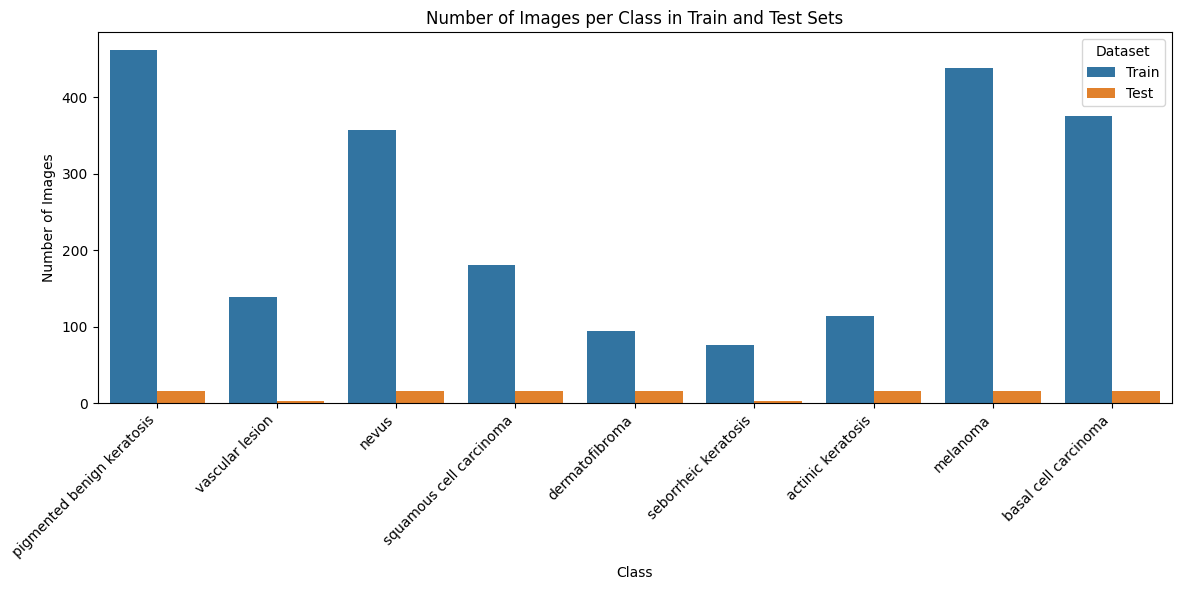

In [ ]:

def count_images_per_class(data_dir):
  """Counts the number of images for each class in a directory."""
  class_counts = {}
  for class_dir in data_dir.glob('*'):
    if class_dir.is_dir():
      class_name = class_dir.name
      class_counts[class_name] = len(list(class_dir.glob('*.jpg')))
  return class_counts

train_counts = count_images_per_class(data_dir_train)
test_counts = count_images_per_class(data_dir_test)

# Create a DataFrame for easier plotting
df_train = pd.DataFrame({'Dataset': 'Train', 'Class': list(train_counts.keys()), 'Count': list(train_counts.values())})
df_test = pd.DataFrame({'Dataset': 'Test', 'Class': list(test_counts.keys()), 'Count': list(test_counts.values())})
df = pd.concat([df_train, df_test], ignore_index=True)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df)
plt.title('Number of Images per Class in Train and Test Sets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 4: Importing Data and Creating a Dataframe


In [ ]:

train_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        # Use concat instead of append
        train_df = pd.concat([train_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        # Use concat instead of append
        test_df = pd.concat([test_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,image_path,label
0,/content/Skin cancer ISIC The International Sk...,0
1,/content/Skin cancer ISIC The International Sk...,0
2,/content/Skin cancer ISIC The International Sk...,0
3,/content/Skin cancer ISIC The International Sk...,0
4,/content/Skin cancer ISIC The International Sk...,0
...,...,...
2352,/content/Skin cancer ISIC The International Sk...,8
2353,/content/Skin cancer ISIC The International Sk...,8
2354,/content/Skin cancer ISIC The International Sk...,8
2355,/content/Skin cancer ISIC The International Sk...,8


In [ ]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'pigmented benign keratosis',
 1: 'vascular lesion',
 2: 'nevus',
 3: 'squamous cell carcinoma',
 4: 'dermatofibroma',
 5: 'seborrheic keratosis',
 6: 'actinic keratosis',
 7: 'melanoma',
 8: 'basal cell carcinoma'}

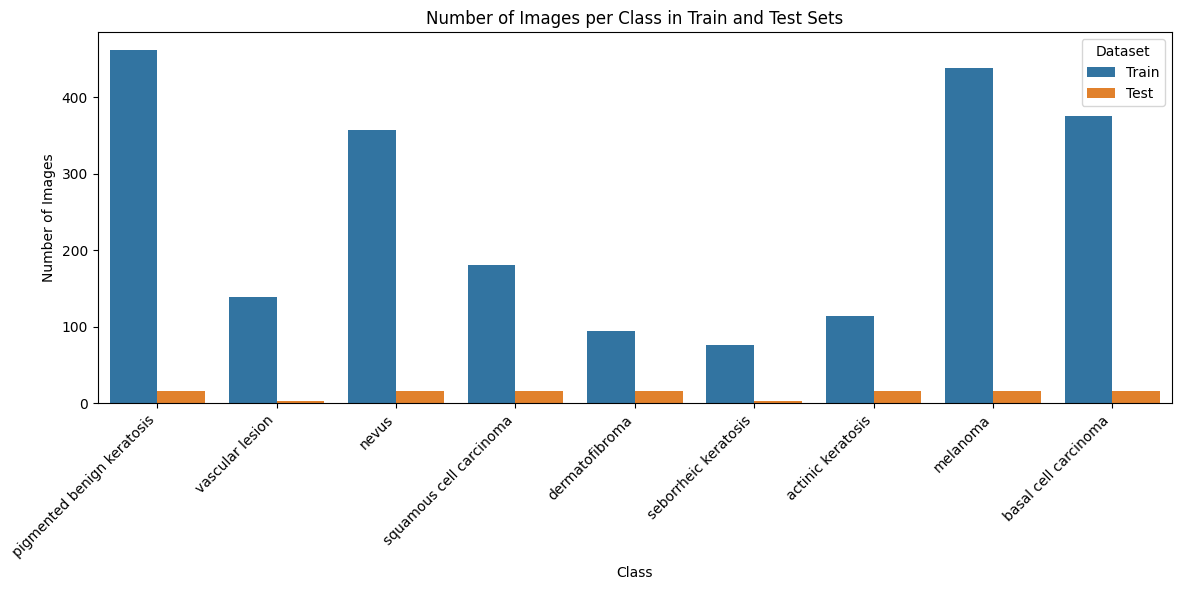

In [ ]:
# Calculate class counts
class_counts = df['label'].value_counts()

def count_images_per_class(data_dir):
  """Counts the number of images for each class in a directory."""
  class_counts = {}
  for class_dir in data_dir.glob('*'):
    if class_dir.is_dir():
      class_name = class_dir.name
      class_counts[class_name] = len(list(class_dir.glob('*.jpg')))
  return class_counts

train_counts = count_images_per_class(data_dir_train)
test_counts = count_images_per_class(data_dir_test)

# Create a DataFrame for easier plotting
df_train = pd.DataFrame({'Dataset': 'Train', 'Class': list(train_counts.keys()), 'Count': list(train_counts.values())})
df_test = pd.DataFrame({'Dataset': 'Test', 'Class': list(test_counts.keys()), 'Count': list(test_counts.values())})
df = pd.concat([df_train, df_test], ignore_index=True)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df)
plt.title('Number of Images per Class in Train and Test Sets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               squamous cell carcinoma        197       
1               vascular lesion                142       
2               melanoma                       454       
3               actinic keratosis              130       
4               dermatofibroma                 111       
5               pigmented benign keratosis     478       
6               basal cell carcinoma           392       
7               seborrheic keratosis           80        
8               nevus                          373       
------------------------------------------------------------
Total                                         2357      


# Step 5: Prepare the dataset

In [ ]:

batch_size = 32  # تحديد حجم الباتش (المجموعة) من البيانات في كل عملية تدريب، هنا حددناها كـ 32 صورة
img_height = 180  # تحديد ارتفاع الصورة بالبكسلات
img_width = 180  # تحديد عرض الصورة بالبكسلات
random.seed(123)  # تحديد بذرة عشوائية لضمان تكرار نفس التسلسل العشوائي في كل مرة يتم تشغيل الكود

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 6: Analysing and process the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
-------------------------------------
Class name =  dermatofibroma
count      =  95
-------------------------------------
Class name =  melanoma
count      =  438
-------------------------------------
Class name =  nevus
count      =  357
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
-------------------------------------
Class name =  vascular lesion
count      =  139
-------------------------------------


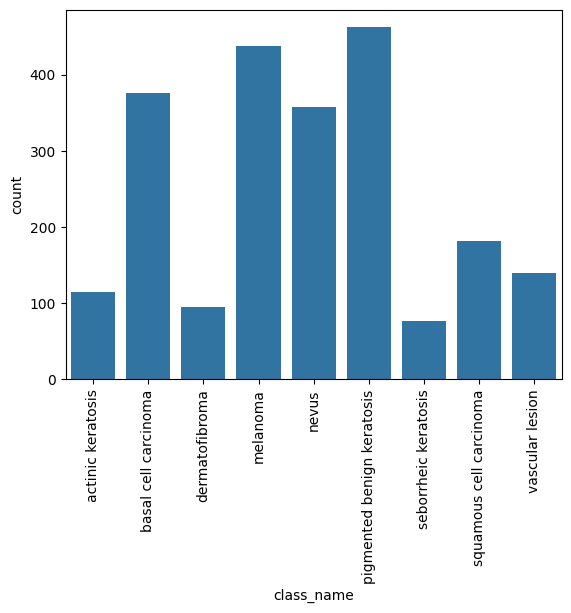

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

### **Findings**
### Data is hevily imbalance and hence due to that results and predictions will be baised.

# Step 7: Augmentor : Class balance

Using Augmentor process the imbalance class of the data

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


path_to_training_dataset = './Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/content/Train_aug/'+i+'/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /content/Train_aug/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C59E8113790>: 100%|██████████| 1000/1000 [00:33<00:00, 30.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Train_aug/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C59F69EAFB0>: 100%|██████████| 1000/1000 [00:31<00:00, 32.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Train_aug/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C59F3BD0670>: 100%|██████████| 1000/1000 [00:33<00:00, 30.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Train_aug/melanoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2816x2112 at 0x7C59E81121A0>: 100%|██████████| 1000/1000 [02:20<00:00,  7.12 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Train_aug/nevus/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7C59F6AF6980>: 100%|██████████| 1000/1000 [02:28<00:00,  6.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Train_aug/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C59F6A4B640>: 100%|██████████| 1000/1000 [00:29<00:00, 34.24 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Train_aug/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C59F6892D40>: 100%|██████████| 1000/1000 [01:09<00:00, 14.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Train_aug/squamous cell carcinoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C59F3BA1E70>: 100%|██████████| 1000/1000 [00:28<00:00, 34.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Train_aug/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C59F5E21ED0>: 100%|██████████| 1000/1000 [00:30<00:00, 32.27 Samples/s]


In [ ]:
output_dir = pathlib.Path('/content/Train_aug/')
image_count_train = len(list(output_dir.glob('**/*.jpg')))
print(image_count_train)

total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
-------------------------------------
Class name =  dermatofibroma
count      =  1000
-------------------------------------
Class name =  melanoma
count      =  1000
-------------------------------------
Class name =  nevus
count      =  1000
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
-------------------------------------
Class name =  vascular lesion
count      =  1000
-------------------------------------


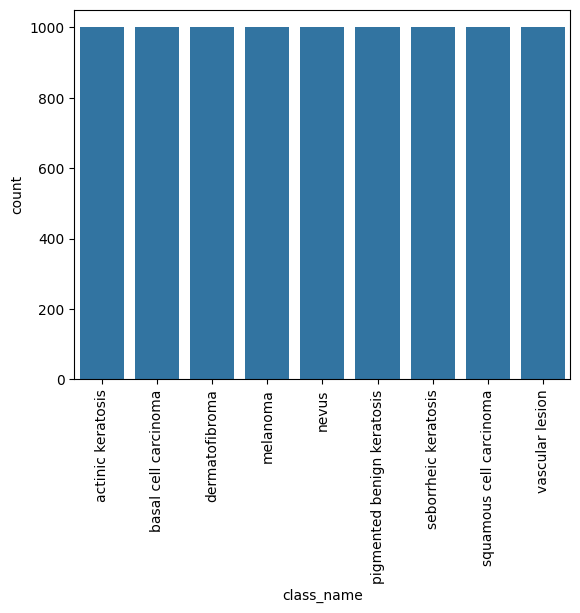

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Step 8: Splitting the dataset after augmentation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Step 9: Model 1 --> CNN Model with Class balance data.

## 9.1 : Building the CNN Model

In [ ]:


num_classes = 9
model = Sequential([
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3))
])
model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
opt = Adam(learning_rate=0.001) # Changed lr to learning_rate
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

## 9.2: Training the CNN model

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


225/225 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.1357 - loss: 2.1590 - val_accuracy: 0.2922 - val_loss: 1.7763
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 63s 114ms/step - accuracy: 0.3766 - loss: 1.5808 - val_accuracy: 0.4128 - val_loss: 1.5023
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.4597 - loss: 1.3799 - val_accuracy: 0.5139 - val_loss: 1.2394
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.5249 - loss: 1.2187 - val_accuracy: 0.5128 - val_loss: 1.3300
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.6004 - loss: 1.0203 - val_accuracy: 0.6139 - val_loss: 0.9967
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.6927 - loss: 0.7957 - val_accuracy: 0.6906 - val_loss: 0.8805
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - accuracy: 0.7821 - loss: 0.5857 - val_accuracy: 0.7350 - val_loss: 0.6699
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 109ms/step - accuracy: 0.8539 - loss: 0.3851 - val

## 9.3: display figure of Accuracy and Loss

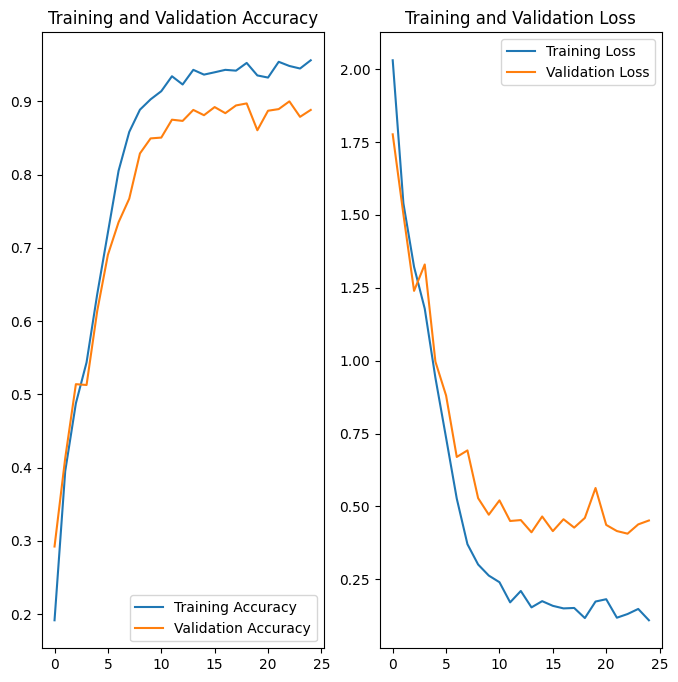

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 9.4: print Accuracy

In [ ]:

print("[INFO] accuracy: {:.2f}%".format(history.history['accuracy'][-1]* 100))

[INFO] accuracy: 95.61%


## 9.5: Save trianed model as file  

In [ ]:

model.save('/content/drive/MyDrive/Colab Notebooks/CNN_model.h5')

# Step 10: Model 2 : MobileNetV3Large Model

## Building the MobileNetV3Large model

In [ ]:
from tensorflow.keras.models import Model # Import the Model class


# ## Building the MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 90, 90, 16)     │            432 │ rescaling_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 90, 90, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 90, 90, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 90, 90, 16)     │            144 │ activation_40[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_38 (ReLU)           │ (None, 90, 90, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 90, 90, 16)     │            256 │ re_lu_38[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 90, 90, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 90, 90, 16)     │              0 │ activation_40[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 90, 90, 64)     │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 90, 90, 64)     │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_39 (ReLU)           │ (None, 90, 90, 64)     │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 3,493,001 (13.32 MB)

 Trainable params: 496,649 (1.89 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Training the MobileNetV3Large model

In [ ]:

# ## Training the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

epochs = 25  # You can adjust the number of epochs
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.3942 - loss: 1.8210 - val_accuracy: 0.6706 - val_loss: 0.9699
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 128ms/step - accuracy: 0.6309 - loss: 1.0092 - val_accuracy: 0.7411 - val_loss: 0.7550
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.7105 - loss: 0.8039 - val_accuracy: 0.7783 - val_loss: 0.6470
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 107ms/step - accuracy: 0.7457 - loss: 0.6925 - val_accuracy: 0.8089 - val_loss: 0.5911
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.7810 - loss: 0.6073 - val_accuracy: 0.8206 - val_loss: 0.5553
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.8016 - loss: 0.5575 - val_accuracy: 0.8383 - val_loss: 0.4942
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.8321 - loss: 0.4729 - val_accuracy: 0.8478 - val_loss: 0.4523
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.8436 - loss: 0

## display figure of Accuracy and Loss

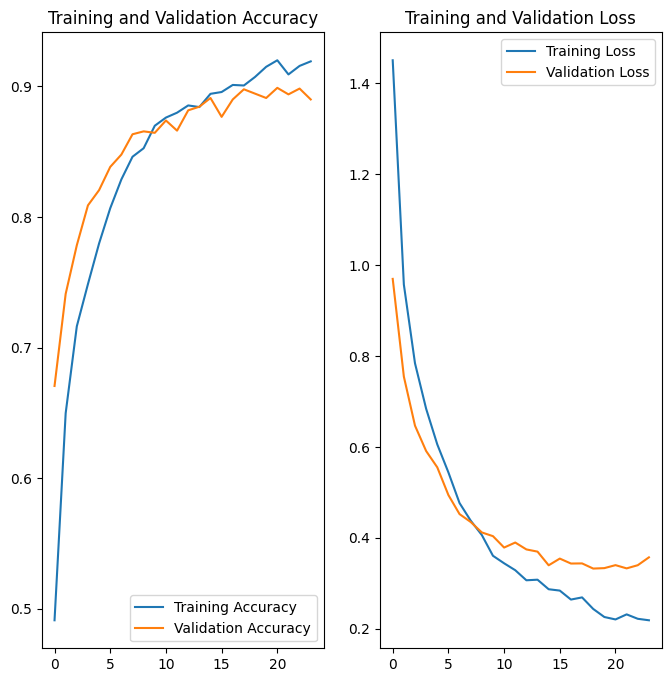

In [ ]:

# Get the actual number of epochs from the training history
epochs_range = range(len(history3.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:


print("[INFO] accuracy: {:.2f}%".format(history3.history['accuracy'][-1]* 100))


[INFO] accuracy: 91.92%


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MobileNetV3_model.h5')

# Step 11: Model 3 : VGG16 Model

## Building the VGG16 model

In [ ]:

# ## Building the VGG16 model
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in VGG16_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = VGG16_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

VGG16_Model = Model(inputs=VGG16_model.input, outputs=predictions)

opt = Adam(learning_rate=0.001)
VGG16_Model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 90, 90, 16)     │            432 │ rescaling_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 90, 90, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 90, 90, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 90, 90, 16)     │            144 │ activation_40[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_38 (ReLU)           │ (None, 90, 90, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 90, 90, 16)     │            256 │ re_lu_38[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 90, 90, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 90, 90, 16)     │              0 │ activation_40[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 90, 90, 64)     │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 90, 90, 64)     │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_39 (ReLU)           │ (None, 90, 90, 64)     │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 3,493,001 (13.32 MB)

 Trainable params: 496,649 (1.89 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Training the VGG16 model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# ## Training the model
epochs = 25  # You can adjust the number of epochs
history4 = VGG16_Model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.3167 - loss: 2.6632 - val_accuracy: 0.6222 - val_loss: 1.1503
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 177ms/step - accuracy: 0.5737 - loss: 1.1784 - val_accuracy: 0.6817 - val_loss: 0.9274
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.6603 - loss: 0.9586 - val_accuracy: 0.7428 - val_loss: 0.7886
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 193ms/step - accuracy: 0.7094 - loss: 0.8238 - val_accuracy: 0.7650 - val_loss: 0.7243
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 186ms/step - accuracy: 0.7572 - loss: 0.7084 - val_accuracy: 0.7967 - val_loss: 0.6542
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.7785 - loss: 0.6424 - val_accuracy: 0.7967 - val_loss: 0.6514
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8040 - loss: 0.5657 - val_accuracy: 0.8289 - val_loss: 0.5934
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.8141 - loss: 0.5506 - val

## Display figure of Accuracy and Loss

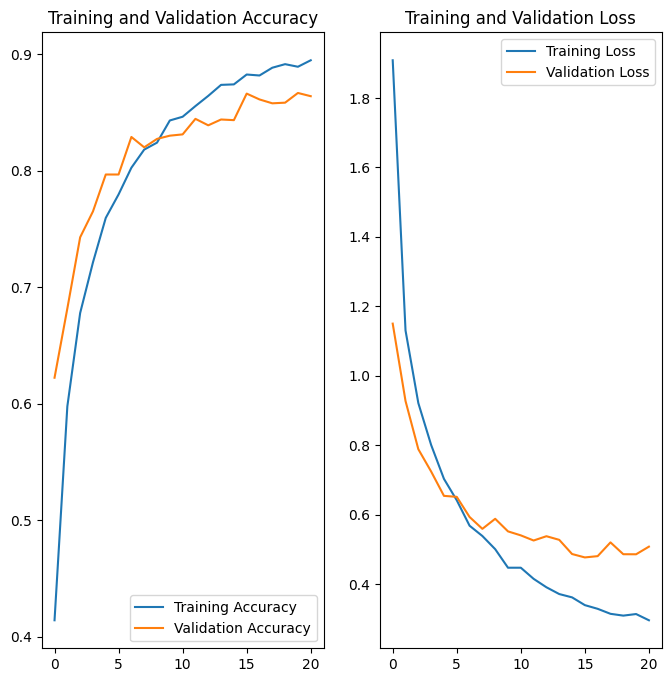

In [ ]:

# Get the actual number of epochs from the training history
epochs_range = range(len(history4.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:


print("[INFO] accuracy: {:.2f}%".format(history4.history['accuracy'][-1]* 100))


[INFO] accuracy: 89.47%


In [ ]:
VGG16_Model.save('/content/drive/MyDrive/Colab Notebooks/VGG16_model.h5')

#Step 11:Model 4: EfficientNet Model

## Building the EfficientNet model

In [ ]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model

# from efficientnet import EfficientNetB4

In [ ]:
num_classes = 9
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 180, 180, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 181, 181, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 90, 90, 48)     │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 90, 90, 48)     │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 90, 90, 48)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 90, 90, 48)     │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 90, 90, 48)     │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 90, 90, 48)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 18,596,456 (70.94 MB)

 Trainable params: 922,633 (3.52 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

## Training the EfficientNet model

In [ ]:

# ## Training the EfficientNet model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# ## Training the model
epochs = 25  # You can adjust the number of epochs
history5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


225/225 ━━━━━━━━━━━━━━━━━━━━ 96s 209ms/step - accuracy: 0.3881 - loss: 1.6992 - val_accuracy: 0.6050 - val_loss: 1.1069
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.5830 - loss: 1.1710 - val_accuracy: 0.6578 - val_loss: 0.9507
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.6336 - loss: 1.0318 - val_accuracy: 0.6856 - val_loss: 0.8436
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.6748 - loss: 0.9097 - val_accuracy: 0.7072 - val_loss: 0.7816
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.7052 - loss: 0.8290 - val_accuracy: 0.7272 - val_loss: 0.7661
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7127 - loss: 0.7917 - val_accuracy: 0.7661 - val_loss: 0.6742
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.7431 - loss: 0.7228 - val_accuracy: 0.7728 - val_loss: 0.6456
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.7347 - loss: 0.7178 - val

## Display figure of Accuracy and Loss

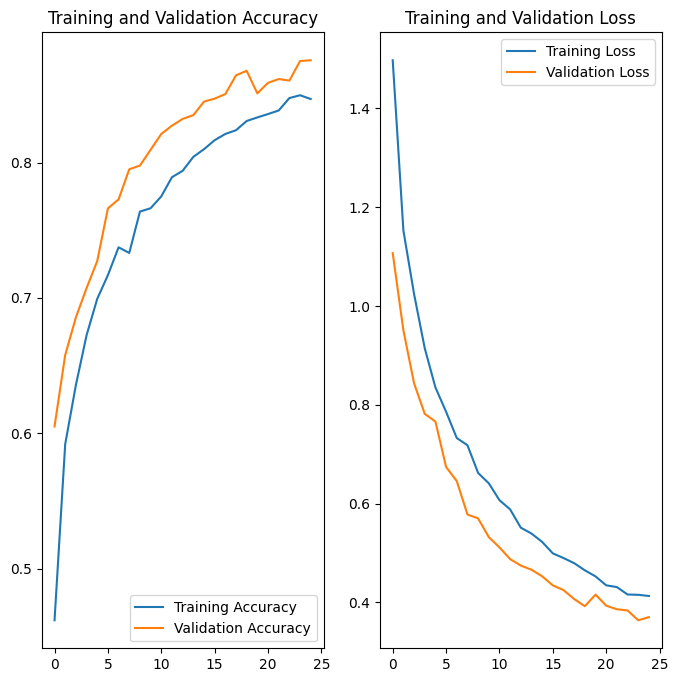

In [ ]:

# ## Display figure of Accuracy and Loss

# Get the actual number of epochs from the training history
epochs_range = range(len(history5.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history5.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history5.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history5.history['loss'], label='Training Loss')
plt.plot(epochs_range, history5.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:

print("[INFO] accuracy: {:.2f}%".format(history5.history['accuracy'][-1]* 100))



[INFO] accuracy: 84.69%


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNet_model.h5')